<a href="https://colab.research.google.com/github/RobCaamano/ResNet50-CNN-Visualization-and-Transfer-Learning/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic.

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


In [ ]:
# ---------- CIFAR-10 Dataset Prep
import numpy as np
import urllib.request
import tarfile
import os

# Open pickle file
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
file = "cifar-10-python.tar.gz"
urllib.request.urlretrieve(url, file)

with tarfile.open(file, "r:gz") as tar:
  tar.extractall()
  tar.close()

base_dir = "cifar-10-batches-py"

meta_batch = unpickle(os.path.join(base_dir, 'batches.meta'))
label_names = [name.decode('utf-8') for name in meta_batch[b'label_names']]
print("Original Label Names:")
print(label_names)

# Filter out 'ship' class
filter_class = label_names.index('ship')
label_names.pop(filter_class)

# Helper function to remove ship class
def filter_and_adjust_labels(data, labels):
    mask = np.array(labels) != filter_class
    filtered_data = data[mask]
    filtered_labels = np.array([label-1 if label > filter_class else label for label in labels if label != filter_class])
    return filtered_data, filtered_labels

# Load train data
train_imgs, train_labels = [], []

for iter in range(1, 6):
    data_batch = unpickle(os.path.join(base_dir, f'data_batch_{iter}'))
    imgs, lbls = filter_and_adjust_labels(data_batch[b'data'], data_batch[b'labels'])
    train_imgs.append(imgs)
    train_labels.extend(lbls)

train_imgs = np.vstack(train_imgs)

# Load test data
test_batch = unpickle(os.path.join(base_dir, 'test_batch'))
test_imgs, test_labels = filter_and_adjust_labels(test_batch[b'data'], test_batch[b'labels'])

# Reshape data
train_imgs = train_imgs.reshape(-1, 32, 32, 3)
test_imgs = test_imgs.reshape(-1, 32, 32, 3)

unique_test_labels = [label_names[i] for i in np.unique(test_labels)]
print("Label Names:", unique_test_labels)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, num_classes=9)
test_labels = to_categorical(test_labels, num_classes=9)

print(train_labels)
print(test_labels)

Original Label Names:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'truck']
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
# ---------- Use ResNet-50 Preprocessing on imgs
from tensorflow.keras.applications.resnet50 import preprocess_input
train_imgs = preprocess_input(train_imgs)
test_imgs = preprocess_input(test_imgs)

In [ ]:
# ---------- ResNet-50 CNN for K=9 Classes
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

# ResNet-50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# CNN for 9 Class Task
cnn_model = Sequential()
cnn_model.add(base_model)
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(9, activation='softmax'))

# Compile CNN
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN
#cnn_model.fit(train_imgs, train_labels, epochs=10, batch_size=32, validation_data=(test_imgs, test_labels))
#cnn_model.save('resnet_cnn.keras')

In [ ]:
# ---------- Load Trained Model & Prepare Cat Img

# Load Model
from keras.models import load_model
model = load_model('resnet_cnn.keras')

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24641417 (94.00 MB)
Trainable params: 24588297 (93.80 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


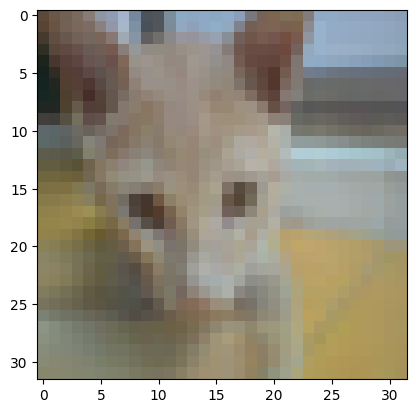

(1, 32, 32, 3)


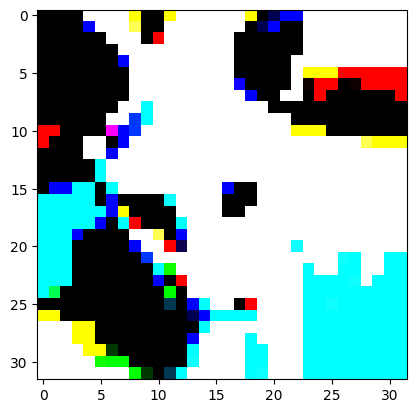

In [ ]:
# Import and Preprocess img
img_path = 'cat1.png'

import numpy as np

import matplotlib.pyplot as plt

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.show()

img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# ---------- Visualizing intermediate convnet outputs (“intermediate activations”)

# Extract the layers from base ResNet-50 model
resnet_layers = []
for layer in model.layers:
    if isinstance(layer, tf.keras.models.Model):
        for sub_layer in layer.layers:
            resnet_layers.append(sub_layer.name)
    else:
        resnet_layers.append(layer.name)
print(', '.join(resnet_layers))

resnet_submodel = model.get_layer("resnet50")

# Intermediate activations
beg_layers = "conv1_conv"
mid_layers = "conv3_block4_1_conv"
end_layers = "conv4_block5_1_conv"

layer_names = [beg_layers, mid_layers, end_layers]

layer_outputs = [resnet_submodel.get_layer(beg_layers).output,
                 resnet_submodel.get_layer(mid_layers).output,
                 resnet_submodel.get_layer(end_layers).output]

activation_model = tf.keras.models.Model(inputs=resnet_submodel.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

input_1, conv1_pad, conv1_conv, conv1_bn, conv1_relu, pool1_pad, pool1_pool, conv2_block1_1_conv, conv2_block1_1_bn, conv2_block1_1_relu, conv2_block1_2_conv, conv2_block1_2_bn, conv2_block1_2_relu, conv2_block1_0_conv, conv2_block1_3_conv, conv2_block1_0_bn, conv2_block1_3_bn, conv2_block1_add, conv2_block1_out, conv2_block2_1_conv, conv2_block2_1_bn, conv2_block2_1_relu, conv2_block2_2_conv, conv2_block2_2_bn, conv2_block2_2_relu, conv2_block2_3_conv, conv2_block2_3_bn, conv2_block2_add, conv2_block2_out, conv2_block3_1_conv, conv2_block3_1_bn, conv2_block3_1_relu, conv2_block3_2_conv, conv2_block3_2_bn, conv2_block3_2_relu, conv2_block3_3_conv, conv2_block3_3_bn, conv2_block3_add, conv2_block3_out, conv3_block1_1_conv, conv3_block1_1_bn, conv3_block1_1_relu, conv3_block1_2_conv, conv3_block1_2_bn, conv3_block1_2_relu, conv3_block1_0_conv, conv3_block1_3_conv, conv3_block1_0_bn, conv3_block1_3_bn, conv3_block1_add, conv3_block1_out, conv3_block2_1_conv, conv3_block2_1_bn, conv3_block

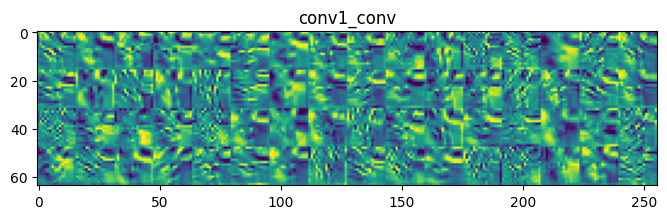

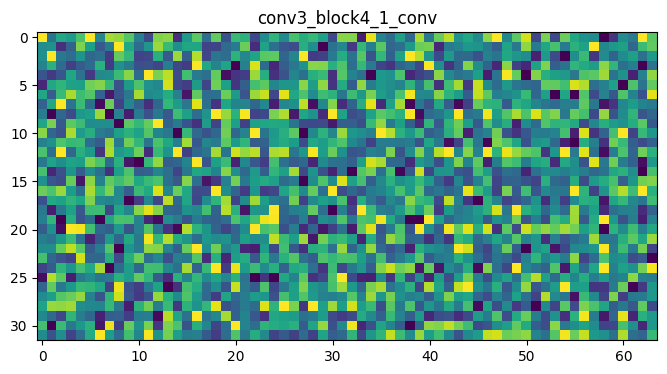

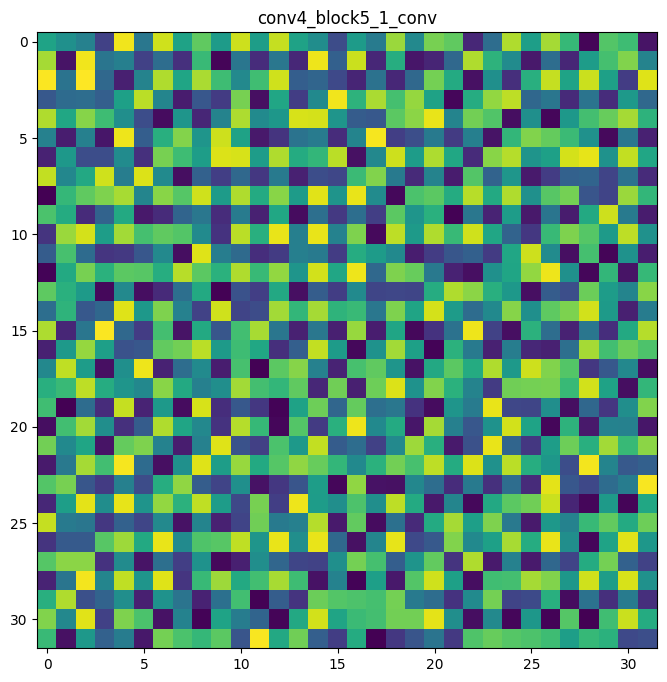

In [ ]:
# ---------- Outputting Images
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 0.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [ ]:
layer_names = [beg_layers, mid_layers, end_layers]

print(resnet_submodel.get_layer(beg_layers).output)
print(resnet_submodel.get_layer(mid_layers).output)
print(resnet_submodel.get_layer(end_layers).output)

Tensor("conv1_conv_1/BiasAdd:0", shape=(None, 16, 16, 64), dtype=float32)
Tensor("conv3_block4_1_conv_1/BiasAdd:0", shape=(None, 4, 4, 128), dtype=float32)
Tensor("conv4_block5_1_conv_1/BiasAdd:0", shape=(None, 2, 2, 256), dtype=float32)


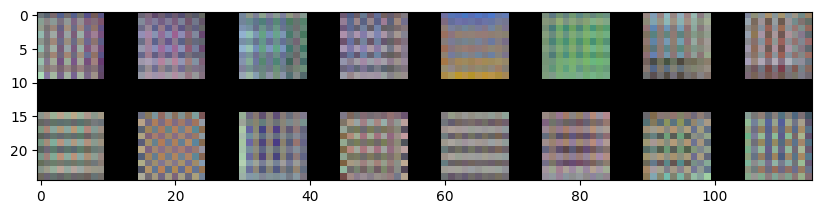

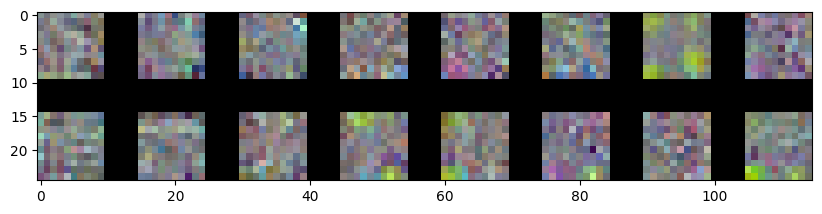

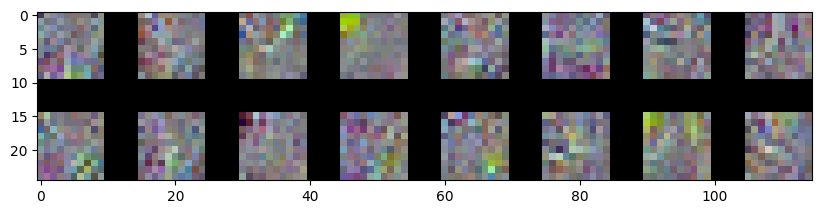

In [ ]:
# ---------- Visualizing convnets filters
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

# Convert img back after preprocessing
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=32):
    layer_output = resnet_submodel.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, resnet_submodel.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([resnet_submodel.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)


for layer_name in layer_names:
    size = 10
    margin = 5

    results = np.zeros((2 * size + 1 * margin, 8 * size + 7 * margin, 3))

    for i in range(2):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i * 8 + j, size=size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 3))
    plt.imshow((results * 255).astype(np.uint8))
    plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
tf.compat.v1.disable_eager_execution()

model = load_model('resnet_cnn.keras')
resnet_submodel = model.get_layer("resnet50")

img_path = 'cat1.png'
img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
# ---------- Visualizing heatmaps of class activation in an image
preds = model.predict(x)
predicted_class_index = np.argmax(preds[0])
print(f"Predicted class index: {predicted_class_index}")

predicted_class_output = model.output[:, predicted_class_index]

last_conv_layer = resnet_submodel.get_layer("conv5_block3_3_conv")

grads = K.gradients(predicted_class_output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

Predicted class index: 4
None


AttributeError: ignored

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('images/predicted_class_cam.jpg', superimposed_img)

## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model.

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`.

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [ ]:
# ---------- Data prep for binary classification
base_dir = "cifar-10-batches-py"

meta_batch = unpickle(os.path.join(base_dir, 'batches.meta'))
label_names = [name.decode('utf-8') for name in meta_batch[b'label_names']]
print("Original Label Names:")
print(label_names)

# Save index of 'ship' class
ship_class = label_names.index('ship')

# Helper function to convert labels to binary (ship vs. no ship)
def convert_to_binary_labels(data, labels):
    binary_labels = [1 if label == ship_class else 0 for label in labels]
    return data, binary_labels

# Load train data
train_imgs, train_labels = [], []

for iter in range(1, 6):
    data_batch = unpickle(os.path.join(base_dir, f'data_batch_{iter}'))
    imgs, lbls = convert_to_binary_labels(data_batch[b'data'], data_batch[b'labels'])
    train_imgs.append(imgs)
    train_labels.extend(lbls)

train_imgs = np.vstack(train_imgs)

# Load test data
test_batch = unpickle(os.path.join(base_dir, 'test_batch'))
test_imgs, test_labels = convert_to_binary_labels(test_batch[b'data'], test_batch[b'labels'])

# Reshape data
train_imgs = train_imgs.reshape(-1, 32, 32, 3)
test_imgs = test_imgs.reshape(-1, 32, 32, 3)

unique_test_labels = np.unique(test_labels)
print("Label Names (Binary):", unique_test_labels)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

print(train_labels)
print(test_labels)

Original Label Names:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label Names (Binary): [0 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# ---------- Using Finetuning
from tensorflow.keras.layers import Dense, Flatten, Input

# Load the trained PS-1A model
cnn_model = tf.keras.models.load_model('resnet_cnn.keras')

# Unfreeze the top layers of the model
for layer in cnn_model.layers[-20:]:
    layer.trainable = True

# Modify for binary classification
cnn_model.pop()
cnn_model.add(Dense(2, activation='softmax', name='binary_output'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(train_imgs, train_labels, epochs=10, batch_size=32, validation_data=(test_imgs, test_labels))
cnn_model.save('resnet_cnn_finetune.keras')

In [ ]:
# ---------- Using Feature Extraction
ps1 = tf.keras.models.load_model('resnet_cnn.keras')
for layer in ps1.layers:
    layer.trainable = False

model_features = tf.keras.models.Sequential([
    ps1,
    Dense(2, activation='softmax')
])

model_features.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                 loss='categorical_crossentropy', metrics=['accuracy'])

model_features.fit(train_imgs, train_labels, epochs=5, batch_size=32, validation_data=(test_imgs, test_labels))
cnn_model.save('resnet_cnn_features.keras')

In [ ]:
# ---------- Load Fine-tuned and Feature Extraction model
import tensorflow as tf
from keras.models import load_model
# For finetuning model
finetuned_model = tf.keras.models.load_model('resnet_cnn_finetune.keras')

# For feature extraction model
feature_extracted_model = tf.keras.models.load_model('resnet_cnn_features.keras')

Instructions for updating:
Colocations handled automatically by placer.


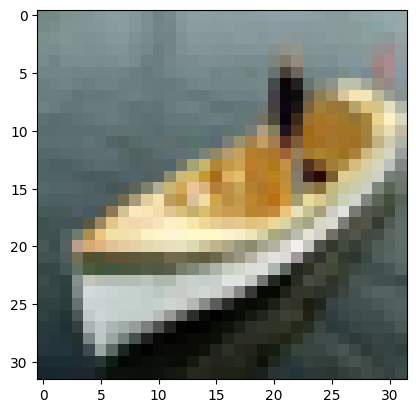

(1, 32, 32, 3)


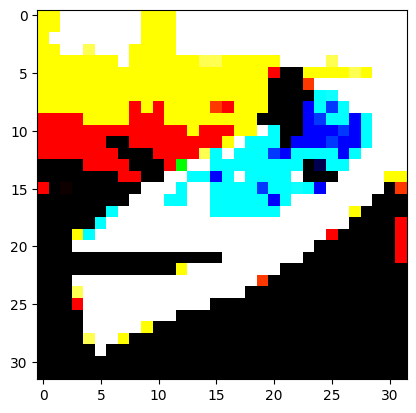

In [ ]:
# Import and Preprocess img
img_path = 'ship7.png'

import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.show()

img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# ---------- Finetuned Vizualizations
beg_layers = "conv1_conv"
mid_layers = "conv3_block4_1_conv"
end_layers = "conv4_block5_1_conv"

layer_names = [beg_layers, mid_layers, end_layers]

resnet_submodel_finetuned = finetuned_model.get_layer("resnet50")

layer_outputs = [resnet_submodel_finetuned.get_layer(beg_layers).output,
                 resnet_submodel_finetuned.get_layer(mid_layers).output,
                 resnet_submodel_finetuned.get_layer(end_layers).output]

activation_model_finetuned = tf.keras.models.Model(inputs=resnet_submodel_finetuned.input, outputs=layer_outputs)

activations_finetuned = activation_model_finetuned.predict(img_tensor)

1/1 [==============================] - 1s 1s/step


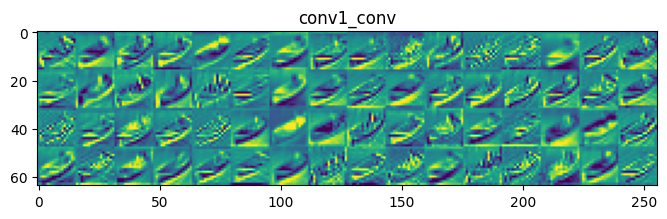

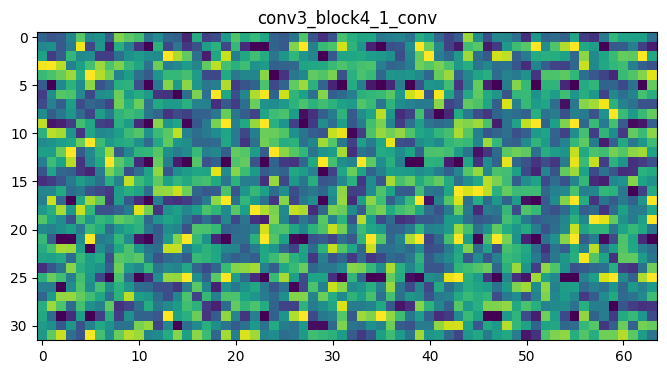

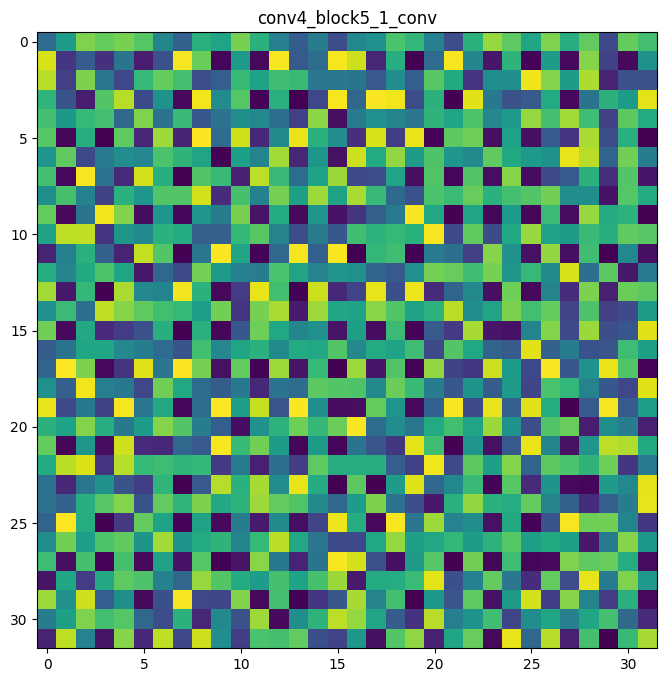

In [ ]:
# ---------- Outputting Images
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_finetuned):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 0.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

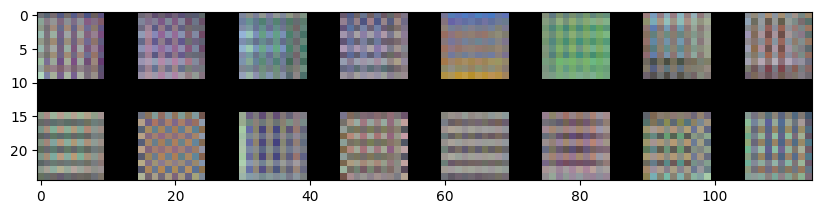

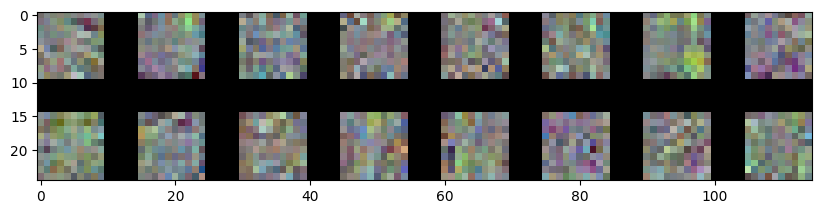

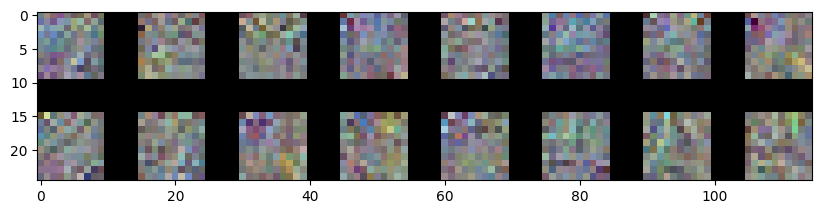

In [ ]:
# ---------- Visualizing convnets filters
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

# Convert img back after preprocessing
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=32):
    layer_output = resnet_submodel_finetuned.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, resnet_submodel_finetuned.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([resnet_submodel_finetuned.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)


for layer_name in layer_names:
    size = 10
    margin = 5

    results = np.zeros((2 * size + 1 * margin, 8 * size + 7 * margin, 3))

    for i in range(2):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i * 8 + j, size=size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 3))
    plt.imshow((results * 255).astype(np.uint8))
    plt.show()

In [ ]:
# ---------- Feature Extraction Vizualizations

sequential_layer = feature_extracted_model.layers[0]
resnet_submodel_features = sequential_layer.layers[0]

layer_outputs = [resnet_submodel_features.get_layer(beg_layers).output,
                 resnet_submodel_features.get_layer(mid_layers).output,
                 resnet_submodel_features.get_layer(end_layers).output]

activation_model_features = tf.keras.models.Model(inputs=resnet_submodel_features.input, outputs=layer_outputs)

activations_features = activation_model_features.predict(img_tensor)

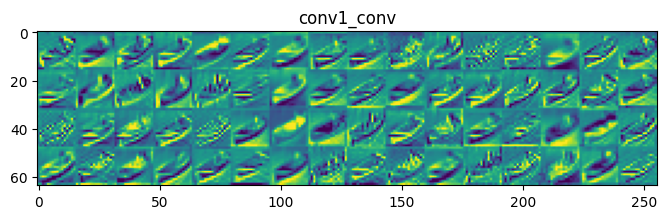

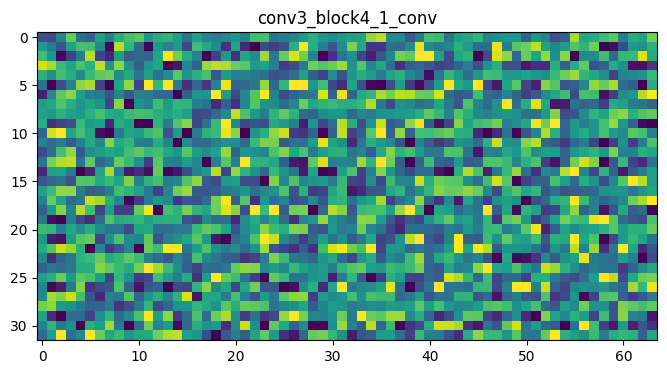

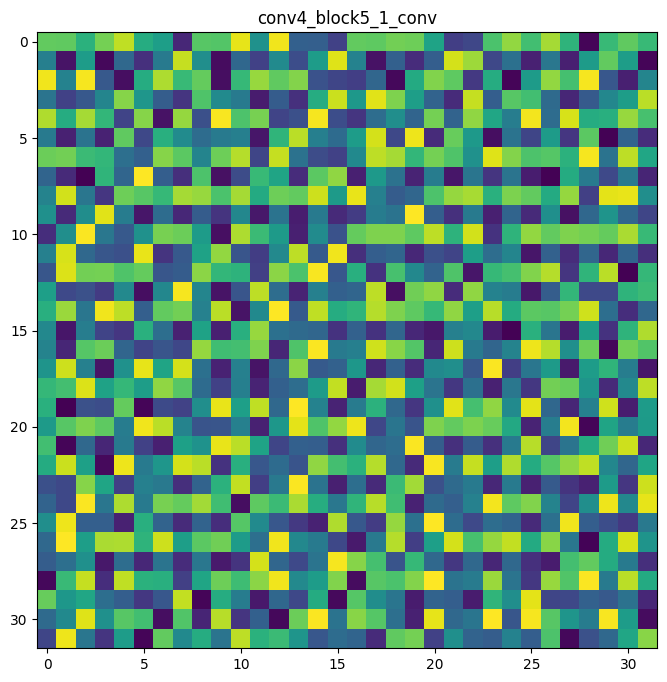

In [ ]:
# ---------- Outputting Images
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_features):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 0.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

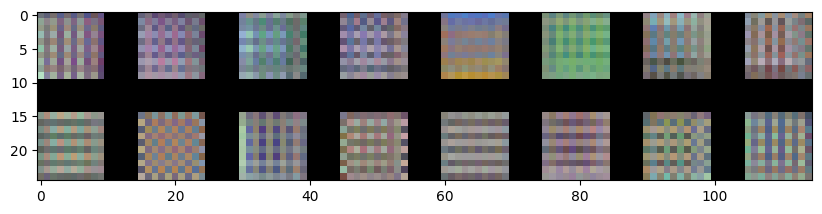

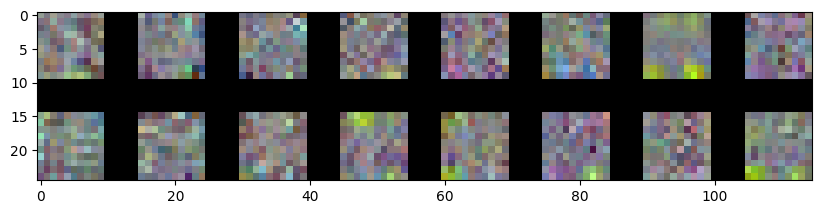

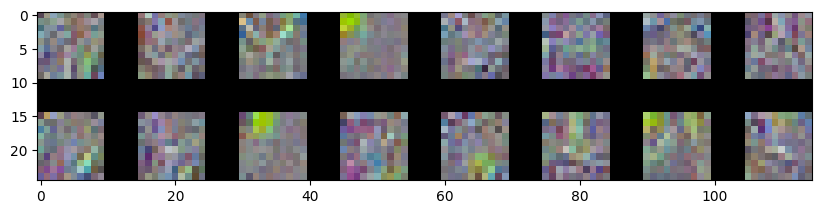

In [ ]:
# ---------- Visualizing convnets filters
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

# Convert img back after preprocessing
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=32):
    layer_output = resnet_submodel_features.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, resnet_submodel_features.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([resnet_submodel_features.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)


for layer_name in layer_names:
    size = 10
    margin = 5

    results = np.zeros((2 * size + 1 * margin, 8 * size + 7 * margin, 3))

    for i in range(2):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i * 8 + j, size=size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 3))
    plt.imshow((results * 255).astype(np.uint8))
    plt.show()